폐렴 진단기
=========
### 사용할 라이브러리 import

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

### 필요한 변수들을 생성

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 32
EPOCHS = 30

print(ROOT_PATH)

/aiffel/aiffel


### 데이터 가져오기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


#### validation data의 개수가 너무 적기 때문에 train data에서 validation에 사용할 data를 가져오기
train data와 validation data를 filenames에 담고 8:2로 데이터를 나눔

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


#### 파일 경로를 print 해보니 경로에 폐렴 이미지와 정상 이미지가 적혀 있음

In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1125_bacteria_3066.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


#### 파일 경로의 NORMAL과 PNEUMONIA의 개수를 통해서 train data의 정상 이미지와 폐렴 이미지의 개수를 세어봄

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1080
Pneumonia images count in training set: 3105


#### mini-batch를 사용하기 위해서 tf.data 인스턴스를 만들어줌

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

#### train dataset과 validation dataset를 count

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


#### 파일 경로를 통해서 라벨 데이터를 만들어주는 함수

In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

#### 이미지의 형식을 바꾸는 함수
#### 파일 경로에서 이미지와 라벨을 가져오는 함수

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

#### train dataset & validation dataset

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

#### 이미지의 사이즈와 라벨을 확인

In [12]:
for image, label in train_ds.take(1): # train_ds.take(1)은 하나의 데이터만 가져옴
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


#### test dataset 생성

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


#### 데이터를 변환시키는 함수

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) # buffer size를 100으로 고정, 무작위로 균일하게 다음 요소 선택
    ds = ds.repeat() # 여러 번 데이터셋을 사용하게 함
    ds = ds.batch(BATCH_SIZE) # 배치 사이즈 지정
    ds = ds.prefetch(buffer_size=AUTOTUNE) # 학습 데이터를 나누어 가져옴, 리소스의 유휴 상태를 줄임
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 데이터 시각화

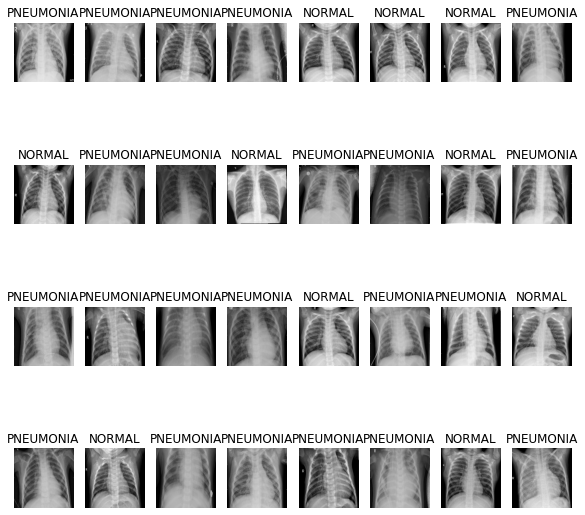

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### CNN 모델링

#### Convolution Block

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

#### Dense Block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

#### model을 build 하는 함수

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 데이터 imbalance 처리

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.94
Weight for PNEUMONIA: 0.67


### 모델 훈련

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

#### 모델 학습

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/30
130/130 [==============================] - 73s 370ms/step - loss: 0.4214 - accuracy: 0.7772 - precision: 0.9485 - recall: 0.7398 - val_loss: 0.5921 - val_accuracy: 0.7441 - val_precision: 0.7441 - val_recall: 1.0000
Epoch 2/30
130/130 [==============================] - 49s 375ms/step - loss: 0.2241 - accuracy: 0.9144 - precision: 0.9796 - recall: 0.9034 - val_loss: 0.8414 - val_accuracy: 0.7402 - val_precision: 0.7402 - val_recall: 1.0000
Epoch 3/30
130/130 [==============================] - 50s 387ms/step - loss: 0.1643 - accuracy: 0.9380 - precision: 0.9790 - recall: 0.9366 - val_loss: 0.8715 - val_accuracy: 0.7422 - val_precision: 0.7422 - val_recall: 1.0000
Epoch 4/30
130/130 [==============================] - 50s 386ms/step - loss: 0.1597 - accuracy: 0.9425 - precision: 0.9795 - recall: 0.9424 - val_loss: 0.9868 - val_accuracy: 0.7422 - val_precision: 0.7422 - val_recall: 1.0000
Epoch 5/30
130/130 [==============================] - 52s 404ms/step - loss: 0.1372 - accura

### 결과 확인

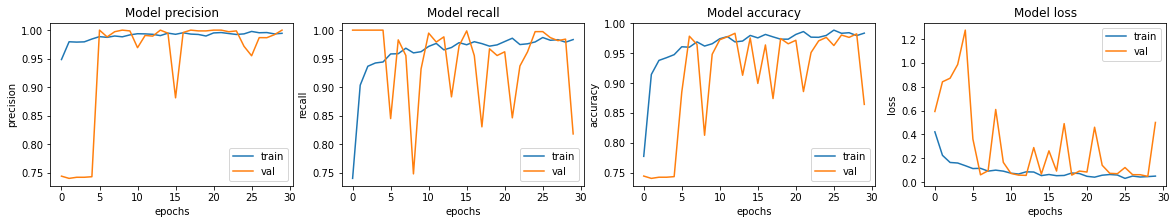

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 6s 281ms/step - loss: 0.4774 - accuracy: 0.8846 - precision: 0.9297 - recall: 0.8821
Loss: 0.4774189889431,
Accuracy: 0.8846153616905212,
Precision: 0.929729700088501,
Recall: 0.8820512890815735


.

회고
==========
제출하는 결과를 보면 Accuracy가 0.8846으로 꽤나 높은 것을 확인할 수 있다. <br>
하지만 Recall이 비교적 낮게 나온 것을 볼 수 있다. <br>
앞서 배운 바로는 의학과 관련한 데이터는 양성을 음성으로 판단하는 것이 위험하기에 Recall이 높으면 좋지 않다고 했다.


그리하여 노드에서 제공하는 좌우반전 함수를 써서 수차례 batch size와 epochs를 바꾸고 다른 것들도 바꿔가면서 Accuracy가 85% 넘기 위해 시도해봤다.<br>
혹시나 해서 validation의 수를 늘려 봤지만 잘 안되었다.<br>
BatchNormalization과 Dropout을 동시에 써서 그런 것인가..? 잘 모르겠다...


쉽지 않았다. 여러번 도전했으나 85%가 넘지 않았기에 Recall은 비교적 낮지만 Accuracy는 기준에 부합하는 결과를 올린다....<br>
그래도 이번 프로젝트도 흥미로웠다.<br>
의학과 관련해서 지식은 없지만 폐렴 환자 여부를 식별한다는 것이 굉장히 신기했다.<br>
의학 관련한 프로젝트가 또 있으면 좋겠다!

화이팅...!
열심히 해봅시다!